# Advanced Lane Finding Project
The goals / steps of this project are the following:
1. Correct Image Distortion: a) Compute the camera calibration matrix and distortion coefficients given a set of chessboard images, b) Apply a distortion correction to raw images.
2. Use color transforms, gradients, etc., to create a thresholded binary image.
3. Apply a perspective transform to rectify binary image ("birds-eye view").
4. Detect lane pixels and fit to find the lane boundary.
5. Determine the curvature of the lane and vehicle position with respect to center.
6. Warp the detected lane boundaries back onto the original image.
7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## 1. Correct Image Distortion
Correction of image distortion (created by the camera) is done in 2 steps:
a) calculate cameral matrix and distortion coefficients and
b) undistort an image using statistics calculated in the step a.

The first step was implemented in a utility class src/CameraCallibration.py. The script in aforementioned file processed all provided examples (chessboard images) and stored resulting stats in src/calibration.p. Therefore, in this book we will focus on the step b).

Step b) consists of creating an CameraCalibration object and using this object to undistort an image. The code for this step provided in the cell below.

In [1]:
import cv2
import numpy as np
from src.CameraCalibration import CameraCalibration as CC
from matplotlib import pyplot as plt
from src.utils import visualize_planes
%matplotlib inline
# Create camera calibration object
calibration_file = "src/calibration.p"
cc = CC(calibration_file)
# Read and undistort an image
test_img_path1 = "test_images/test1.jpg"
test_img_path2 = "test_images/straight_lines1.jpg"
test_img1 = cv2.cvtColor(cv2.imread(test_img_path1), cv2.COLOR_BGR2RGB)
test_img2 = cv2.cvtColor(cv2.imread(test_img_path2), cv2.COLOR_BGR2RGB)
undistorted_img1 = cc.undistort(test_img1, 1)
undistorted_img2 = cc.undistort(test_img2, 1)
undistorted_cropped_img1 = cc.undistort(test_img1)
undistorted_cropped_img2 = cc.undistort(test_img2)

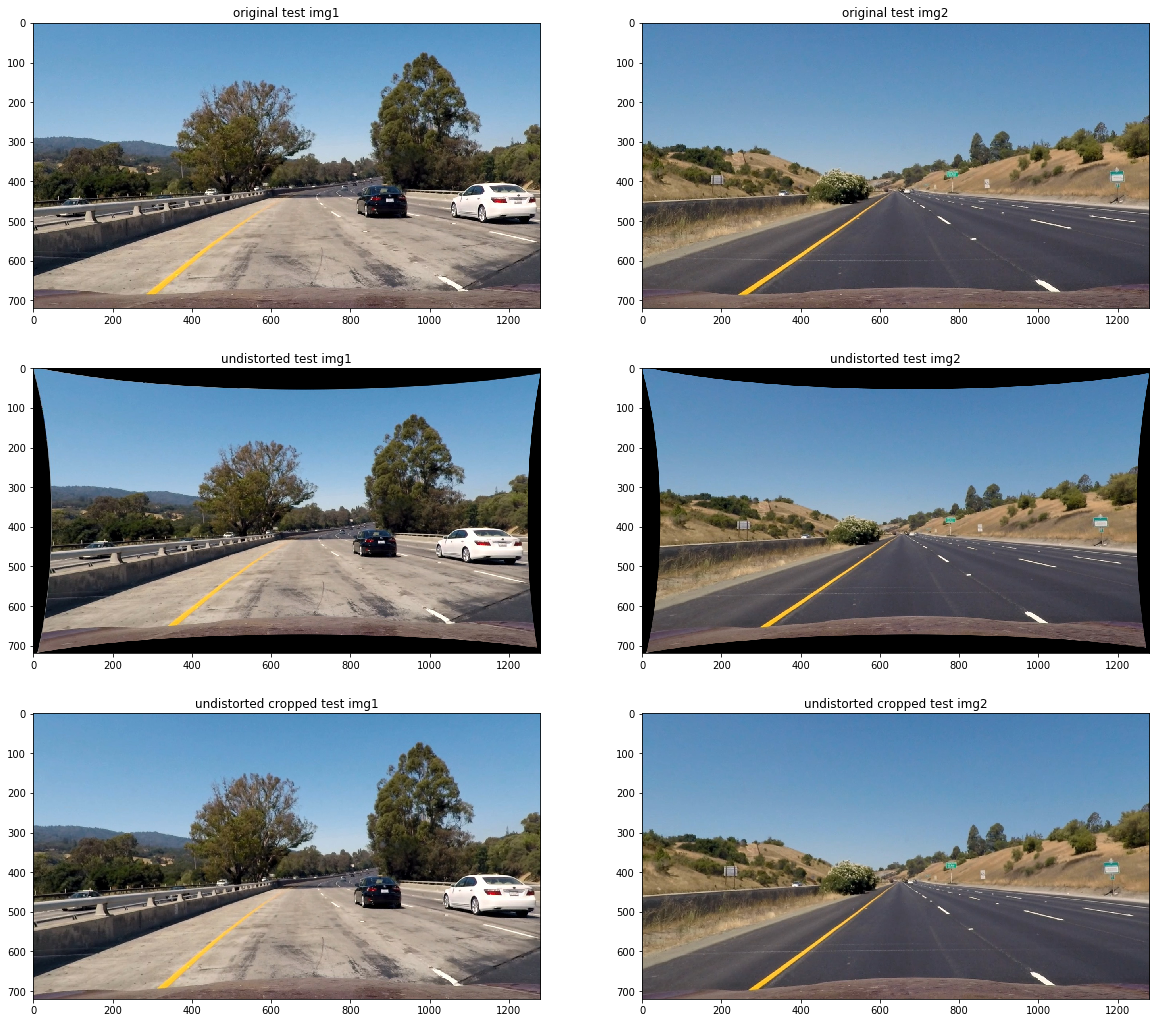

In [2]:
# Visualize resulting images
f = plt.figure(figsize=[20,18])
p1 = f.add_subplot(321)
p1.set_title("original test img1")
p1.imshow(test_img1)
p2 = f.add_subplot(323)
p2.set_title("undistorted test img1")
p2.imshow(undistorted_img1)
p3 = f.add_subplot(325)
p3.set_title("undistorted cropped test img1")
p3.imshow(undistorted_cropped_img1)
p4 = f.add_subplot(322)
p4.set_title("original test img2")
p4.imshow(test_img2)
p5 = f.add_subplot(324)
p5.set_title("undistorted test img2")
p5.imshow(undistorted_img2)
p6 = f.add_subplot(326)
p6.set_title("undistorted cropped test img2")
p6.imshow(undistorted_cropped_img2)

## 2. Use color transforms, gradients, etc., to create a thresholded binary image
Second step includes a raw image transformation into a binary masks by applying conditions to processed image. The image processing step relies on the conversion of the raw image into either a combination of x and y Sobel gradients or using a particular color channel or combination of all.

The code below presents functions allowing to conver your raw images into binary masks.

In [3]:
def abs_sobel_thresh(img, orient='x', kernel=3, thresh=(0,255)):
    """
    Transforms img into a binary mask based on Sobel kernel and provided threshold.
    :param img: input image (1 channel)
    :param orient: orientation of Sobel gradient, eith 'x' or 'y'
    :param kernel: the size of Sobel kernel (the larger the size the smother the gradient)
    :param thresh: condition used to transform the gradient into a binary mask
    :return: one channel image
    """
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel))
    else:
        raise AttributeError("Incorrect orient attribute. orient attribute accepts only 'x' and 'y'")
    # Rescale back to 8 bit integer
    sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    mask = np.zeros_like(sobel)
    mask[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1
    return mask

def mag_thresh(img, kernel=3, thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, kernel=3, thresh=(0, np.pi / 2)):
    """
    Transforms an inputl image into a binary mask based on the direction of the gradient (set in radians).
    :param img: input image (1 channel)
    :param kernel: the size of Sobel kernel (the larger the size the smother the gradient)
    :param thresh: condition used to transform the gradient direction (in radians) into a binary mask
    :return: one channel image (binary mask)
    """
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    mask = np.zeros_like(absgraddir)
    mask[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return np.uint8(mask)

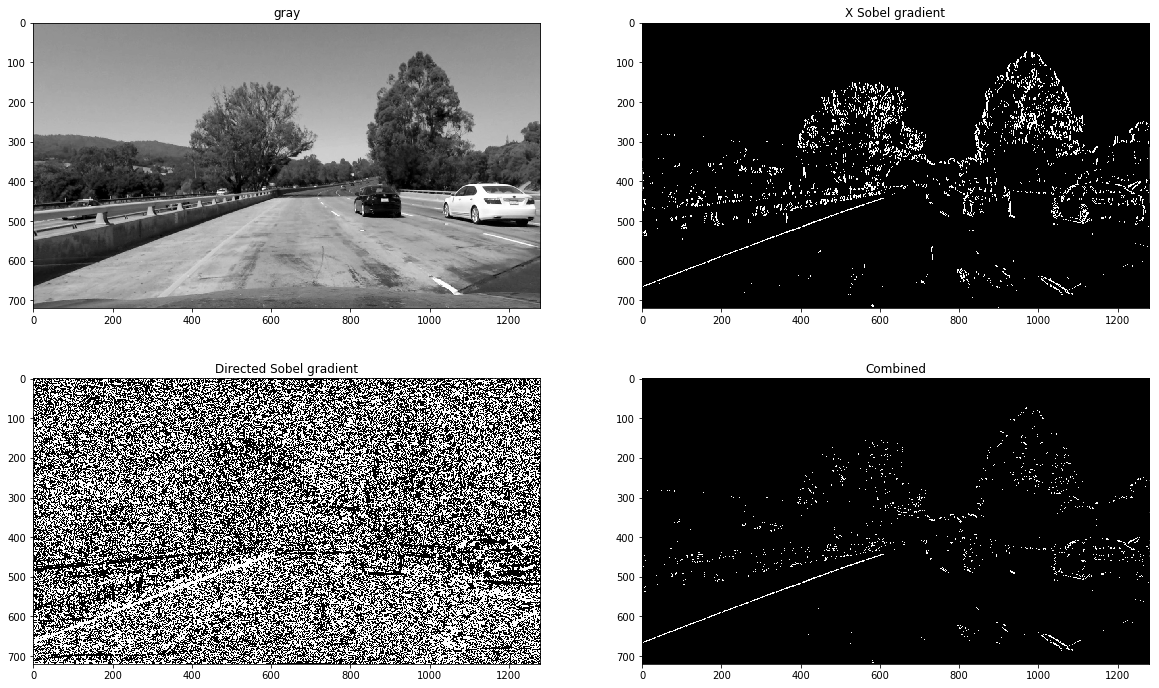

In [4]:
# Convert to grayscale
gray = cv2.cvtColor(undistorted_cropped_img1, cv2.COLOR_RGB2GRAY)
# Transform and visualize images
sobel_x_img = abs_sobel_thresh(gray, orient='x', kernel=7, thresh=(30, 100))
direct_sobel_img = dir_threshold(gray, kernel=7, thresh=(40*np.pi/180, 80*np.pi/180))
combined = np.zeros_like(sobel_x_img, dtype=np.uint8)
combined[(sobel_x_img==1) & (direct_sobel_img==1)] = 1
f, ((p1, p2), (p3, p4)) = plt.subplots(2,2, figsize=[20, 12])
p1.set_title("gray")
p1.imshow(gray, cmap='gray')
p2.set_title("X Sobel gradient")
p2.imshow(sobel_x_img, cmap='gray')
p3.set_title("Directed Sobel gradient")
p3.imshow(direct_sobel_img, cmap='gray')
p4.set_title("Combined")
p4.imshow(combined, cmap='gray')

Based to the results presented above, Sobel gradient with x orientation is a good starting point. However, additional condition set for the direction of the gradient helps to remove some of the noice from the middel part of the image.

Out current approach relies on gray scale image and doesn't use color information. Color information, however, can help to further improve our solution. In order to capture color information, I will convert raw image into hsl image to validate which of the channels provies the best features for lane detection.

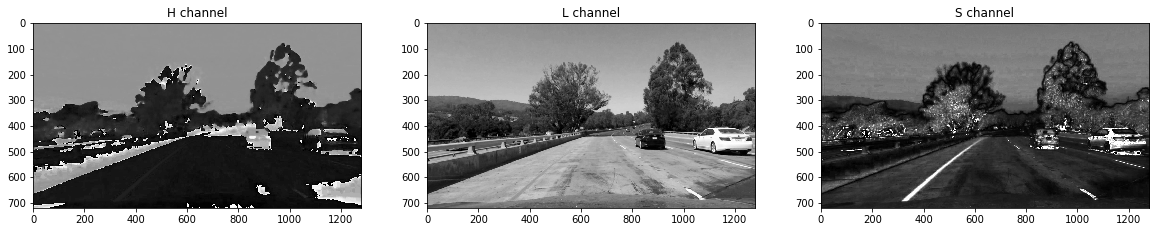

In [5]:
HLS_img = cv2.cvtColor(undistorted_cropped_img1, cv2.COLOR_RGB2HLS)
h, l, s = HLS_img[:,:,0], HLS_img[:,:,1], HLS_img[:,:,2]
f, (p1, p2, p3) = plt.subplots(1,3, figsize=[20, 6])
p1.set_title("H channel")
p1.imshow(h, cmap="gray")
p2.set_title("L channel")
p2.imshow(l, cmap="gray")
p3.set_title("S channel")
p3.imshow(s, cmap="gray")

S (saturation) channel seem to separate lanes vs. background the best. Therefore, I test the application of S channel for lane detection next.

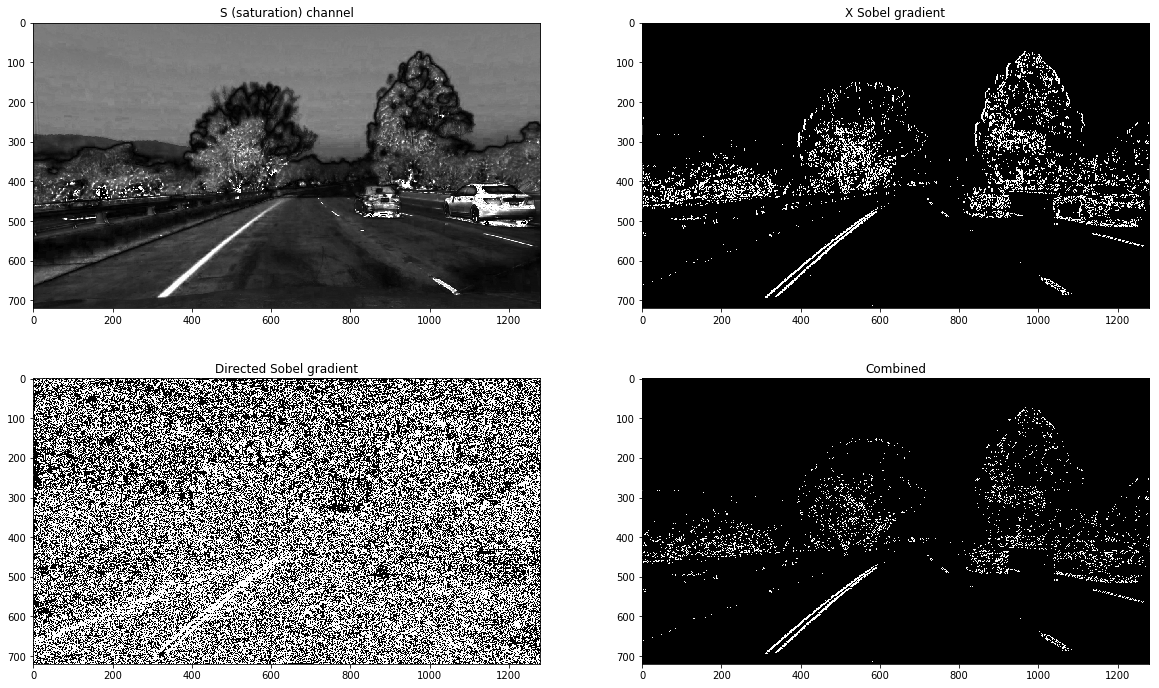

In [6]:
# Transform and visualize images
sobel_x_img = abs_sobel_thresh(s, kernel=3, thresh=(20, 100))
direct_sobel_img = dir_threshold(s, kernel=3, thresh=(30*np.pi/180, 80*np.pi/180))
combined = np.zeros_like(sobel_x_img, dtype=np.uint8)
combined[(sobel_x_img==1) & (direct_sobel_img==1)] = 1
f, ((p1, p2), (p3, p4)) = plt.subplots(2,2, figsize=[20, 12])
p1.set_title("S (saturation) channel")
p1.imshow(s, cmap='gray')
p2.set_title("X Sobel gradient")
p2.imshow(sobel_x_img, cmap='gray')
p3.set_title("Directed Sobel gradient")
p3.imshow(direct_sobel_img, cmap='gray')
p4.set_title("Combined")
p4.imshow(combined, cmap='gray')

## 3. Apply a perspective transform to rectify binary image ("birds-eye view").

To apply a perspective transform I first calculated the coordinates for rectangle that describes the plane on a source (src) and desired image (dst). Then, I created a transformation matrix (cv2.getPerspectiveTransform) and applied this matrix to the image (cv2.warpPerspective).

The transformation script and result of the transformation are presented below:

In [7]:
def warper(img, src=None, dst=None):
    """
    Warps an image input based on provided rectangle coordinates for the source image (src) and 
    the destination image (dst)
    :param img: input image
    :param src: rectangle coordinates for the source image
    :param dst: rectungle coordinates for the destination image
    :return: warped image
    """
    # Set img_size and transformation points
    if len(img.shape)==3:
        img_size = img.shape[:-1][::-1]
    elif len(img.shape)==2:
        img_size = img.shape[::-1]
    else:
        assert False, "Provided image has incorrect shape {}. Image expected to have 2 or 3 dimentions".format(img.shape)
    src = src or np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
                             [((img_size[0] / 6) - 10), img_size[1]],
                             [(img_size[0] * 5 / 6) + 60, img_size[1]],
                             [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = dst or np.float32([[(img_size[0] / 4), 0],
                             [(img_size[0] / 4), img_size[1]],
                             [(img_size[0] * 3 / 4), img_size[1]],
                             [(img_size[0] * 3 / 4), 0]])
    # Create a transformation matrix and warp the image
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, img_size), (src, dst)

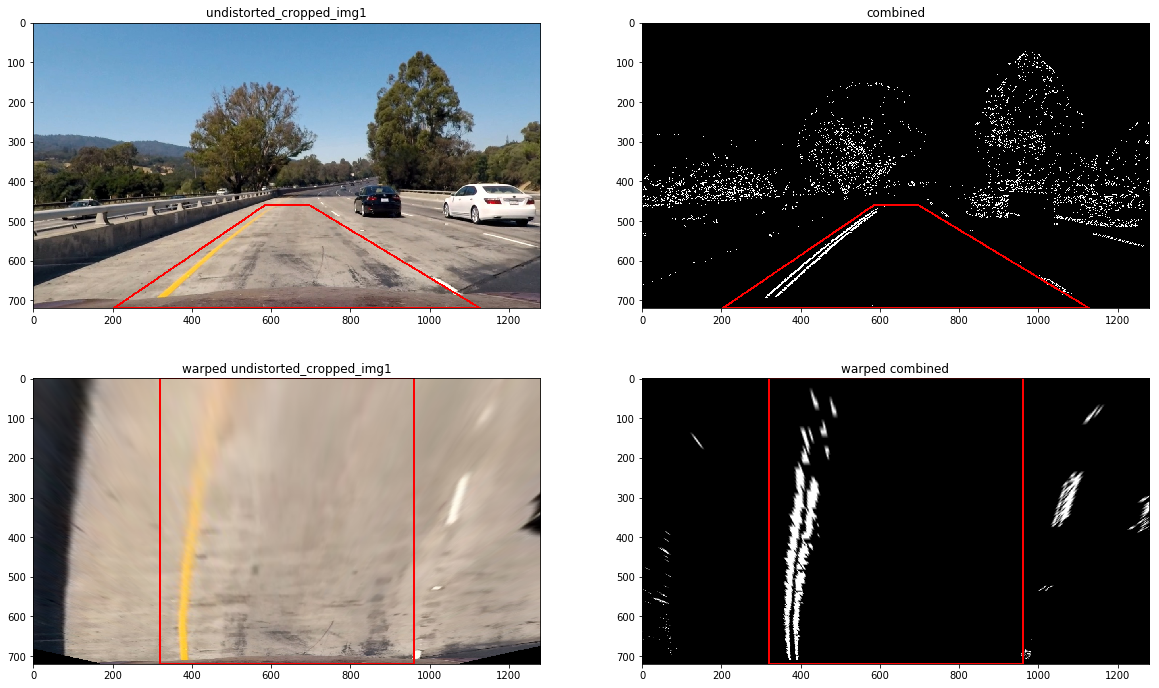

In [8]:
rgb_combined = np.dstack([combined,combined,combined])*255
warped_combined, (src, dst) = warper(rgb_combined)
rgb_combined = visualize_planes(rgb_combined, src)
warped_combined = visualize_planes(warped_combined, dst)
warped_undistorted_cropped_img1, (src, dst) = warper(undistorted_cropped_img1)
undistorted_cropped_img1 = visualize_planes(undistorted_cropped_img1, src)
warped_undistorted_cropped_img1 = visualize_planes(warped_undistorted_cropped_img1, dst)


fig, ((p11, p12),(p21, p22)) = plt.subplots(2,2, figsize=[20,12])
p11.set_title("undistorted_cropped_img1")
p11.imshow(undistorted_cropped_img1)
p21.set_title("warped undistorted_cropped_img1")
p21.imshow(warped_undistorted_cropped_img1)
p12.set_title("combined")
p12.imshow(rgb_combined)
p22.set_title("warped combined")
p22.imshow(warped_combined)